In [23]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd



In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import tensorflow as tf
from scipy.io import wavfile as wav
import warnings
warnings.filterwarnings('ignore')

In [34]:
audio_dataset_path='sound_split/sounds/'
metadata=pd.read_csv('sound_split/Splitmetadata.csv')
mfcc = 50 # öznitelik sayısı
num_labels = 7 # Sınıf sayısı
unique_class = metadata['class_name'].unique()

def features_extractor(filename):
    
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [35]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["file_name"]))
    final_class_labels=row["class_name"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

5178it [07:59, 10.80it/s]


In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [24]:

from keras.models import load_model

model = load_model('urban_model')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

In [25]:

# 2. hidden layer
model.add(Dense(200 ,name="d1"))
model.add(Activation('relu',name ="a1"))

# 3. hidden layer
model.add(Dense(100, name="d2"))
model.add(Activation('relu',name ="a2"))


# output layer
model.add(Dense(7, name="d3"))
model.add(Activation('softmax', name="a3"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

In [38]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy',f1_m, precision_m, recall_m], optimizer='adam')

In [39]:
epochscount = 25
num_batch_size = 32

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25


2022-05-30 02:48:39.565123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.7411 - accuracy: 0.3392 - f1_m: 0.0530 - precision_m: 0.2902 - recall_m: 0.0299

2022-05-30 02:48:44.670447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 6s 22ms/step - loss: 1.7411 - accuracy: 0.3392 - f1_m: 0.0530 - precision_m: 0.2902 - recall_m: 0.0299 - val_loss: 1.3944 - val_accuracy: 0.5338 - val_f1_m: 0.3553 - val_precision_m: 0.8637 - val_recall_m: 0.2285
Epoch 2/25
130/130 [==============================] - 2s 12ms/step - loss: 1.4411 - accuracy: 0.4920 - f1_m: 0.3711 - precision_m: 0.6771 - recall_m: 0.2652 - val_loss: 1.0796 - val_accuracy: 0.6351 - val_f1_m: 0.5362 - val_precision_m: 0.9143 - val_recall_m: 0.3845
Epoch 3/25
130/130 [==============================] - 2s 13ms/step - loss: 1.2041 - accuracy: 0.5843 - f1_m: 0.5349 - precision_m: 0.7533 - recall_m: 0.4210 - val_loss: 0.9420 - val_accuracy: 0.6351 - val_f1_m: 0.6119 - val_precision_m: 0.9415 - val_recall_m: 0.4605
Epoch 4/25
130/130 [==============================] - 2s 12ms/step - loss: 1.0940 - accuracy: 0.6118 - f1_m: 0.5585 - precision_m: 0.8187 - recall_m: 0.4285 - val_loss: 0.9024 - val_accuracy: 0.6583 - val_f1_m:

In [40]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])
print(validation_test_set_accuracy[0])

0.8542470932006836
0.4321366548538208


In [41]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


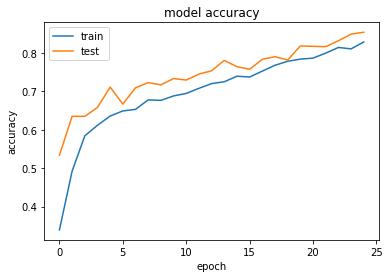

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('c.png')

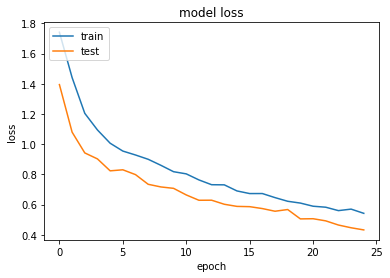

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
print("F1-skor : ",history.history['f1_m'][-1])
print("Precision skor : ",history.history['precision_m'][-1])
print("Recall skor : ",history.history['recall_m'][-1])

F1-skor :  0.8274826407432556
Precision skor :  0.87553471326828
Recall skor :  0.7857829928398132


In [45]:
y_pred = model.predict(X_test)

2022-05-30 02:52:33.733134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [46]:
predict_y, test_y =[],[]
for a in y_pred:
    predict_y.append(np.argmax(a))
for i in y_test:
    test_y.append(np.argmax(i))
print(len(predict_y))
print(len(test_y))

1036
1036


In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, predict_y)

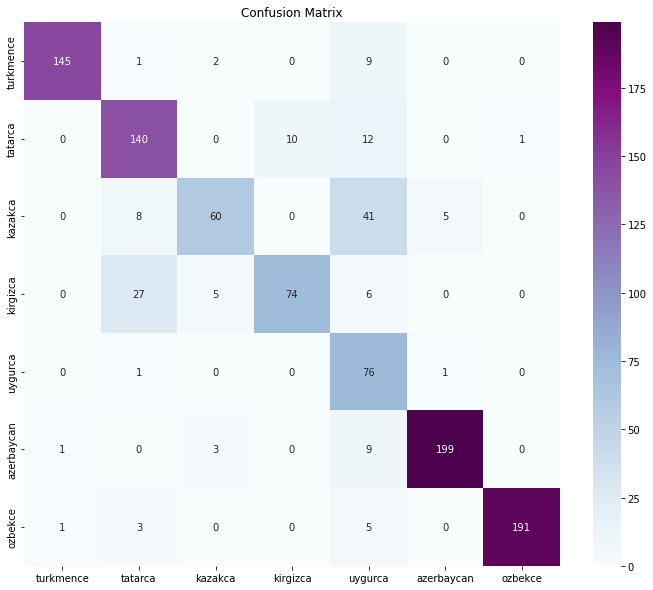

In [48]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in unique_class],
                  columns = [i for i in unique_class])
plt.figure(figsize = (12,10))
plt.title("Confusion Matrix")
ss = sn.heatmap(df_cm, annot=True,fmt="d", cmap="BuPu")
figure = ss.get_figure()    
figure.savefig('tl_conf.png', dpi=400)